## Understanding DBMapper
DBMapper is an algorithm for learning a discrete approximation of the 1-dimensional topology of a manifold. It is a density-sensitive augmentation of the Mapper algorithm in topological data analysis (cite here).

This article will provide a high-level overview of how DBMapper works, and how it differs from Mapper. In theory, DBMapper is founded on Morse theory and persistent homology, but in practice it can be understood without these mathematical tools.

As DBMapper is mostly Mapper, we start with an explanation of Mapper itself.

### Mapper

Mapper helps us describe the topology of a manifold $X$ using a set of samples from the manifold, by approximating the *Reeb graph* of the manifold with respect to some Morse-type function $f:X\to \mathbb{R}$. This Reeb graph is a 1-dimensional representation of $X$, which captures its $0$- and $1$- dimensional topological features; that is, connected components and holes respectively.  

To do this, it constructs a finite graph $G$ as follows:
1. Split $f(X)\subset\mathbb{R}$ into overlapping interval bins $I_1,...,I_N$
2. For each bin $I_k$, cluster all the samples $x$ for which $f(x) \in I_k$.
3. Add a vertex $c^k_i$ to $G$ for each cluster $c_i$ in $I_k$.
4. Add an edge between $c^k_i$ and $c^{k+1}_j$ with weight equal to the number of points their corresponding clusters share in common. 

Let us demonstrate this now with the `TemporalMapper` object.

In [1]:
import temporalmapper as tm
import temporalmapper.utilities_ as tmutils
import numpy as np
import matplotlib.pyplot as plt
import requests, io
from sklearn.cluster import DBSCAN

For this demonstration, we will load a synthetic test file with points sampled from a $2$-dimensional manifold with fairly uniform density.

We will use the $x$-axis as the Morse-type function $f$, called `time` in the code snippets below.

In [2]:
demo_data_file = requests.get("https://github.com/TutteInstitute/temporal-mapper/raw/docs/docs/data/mapper_demo_data.npy")
data_time = np.load(io.BytesIO(demo_data_file.content)) 
data_unsort = data_time[:,1].T
time_unsort = data_time[:,0].T
sorted_indices = np.argsort(time_unsort)
data = data_unsort[sorted_indices]
time = time_unsort[sorted_indices]

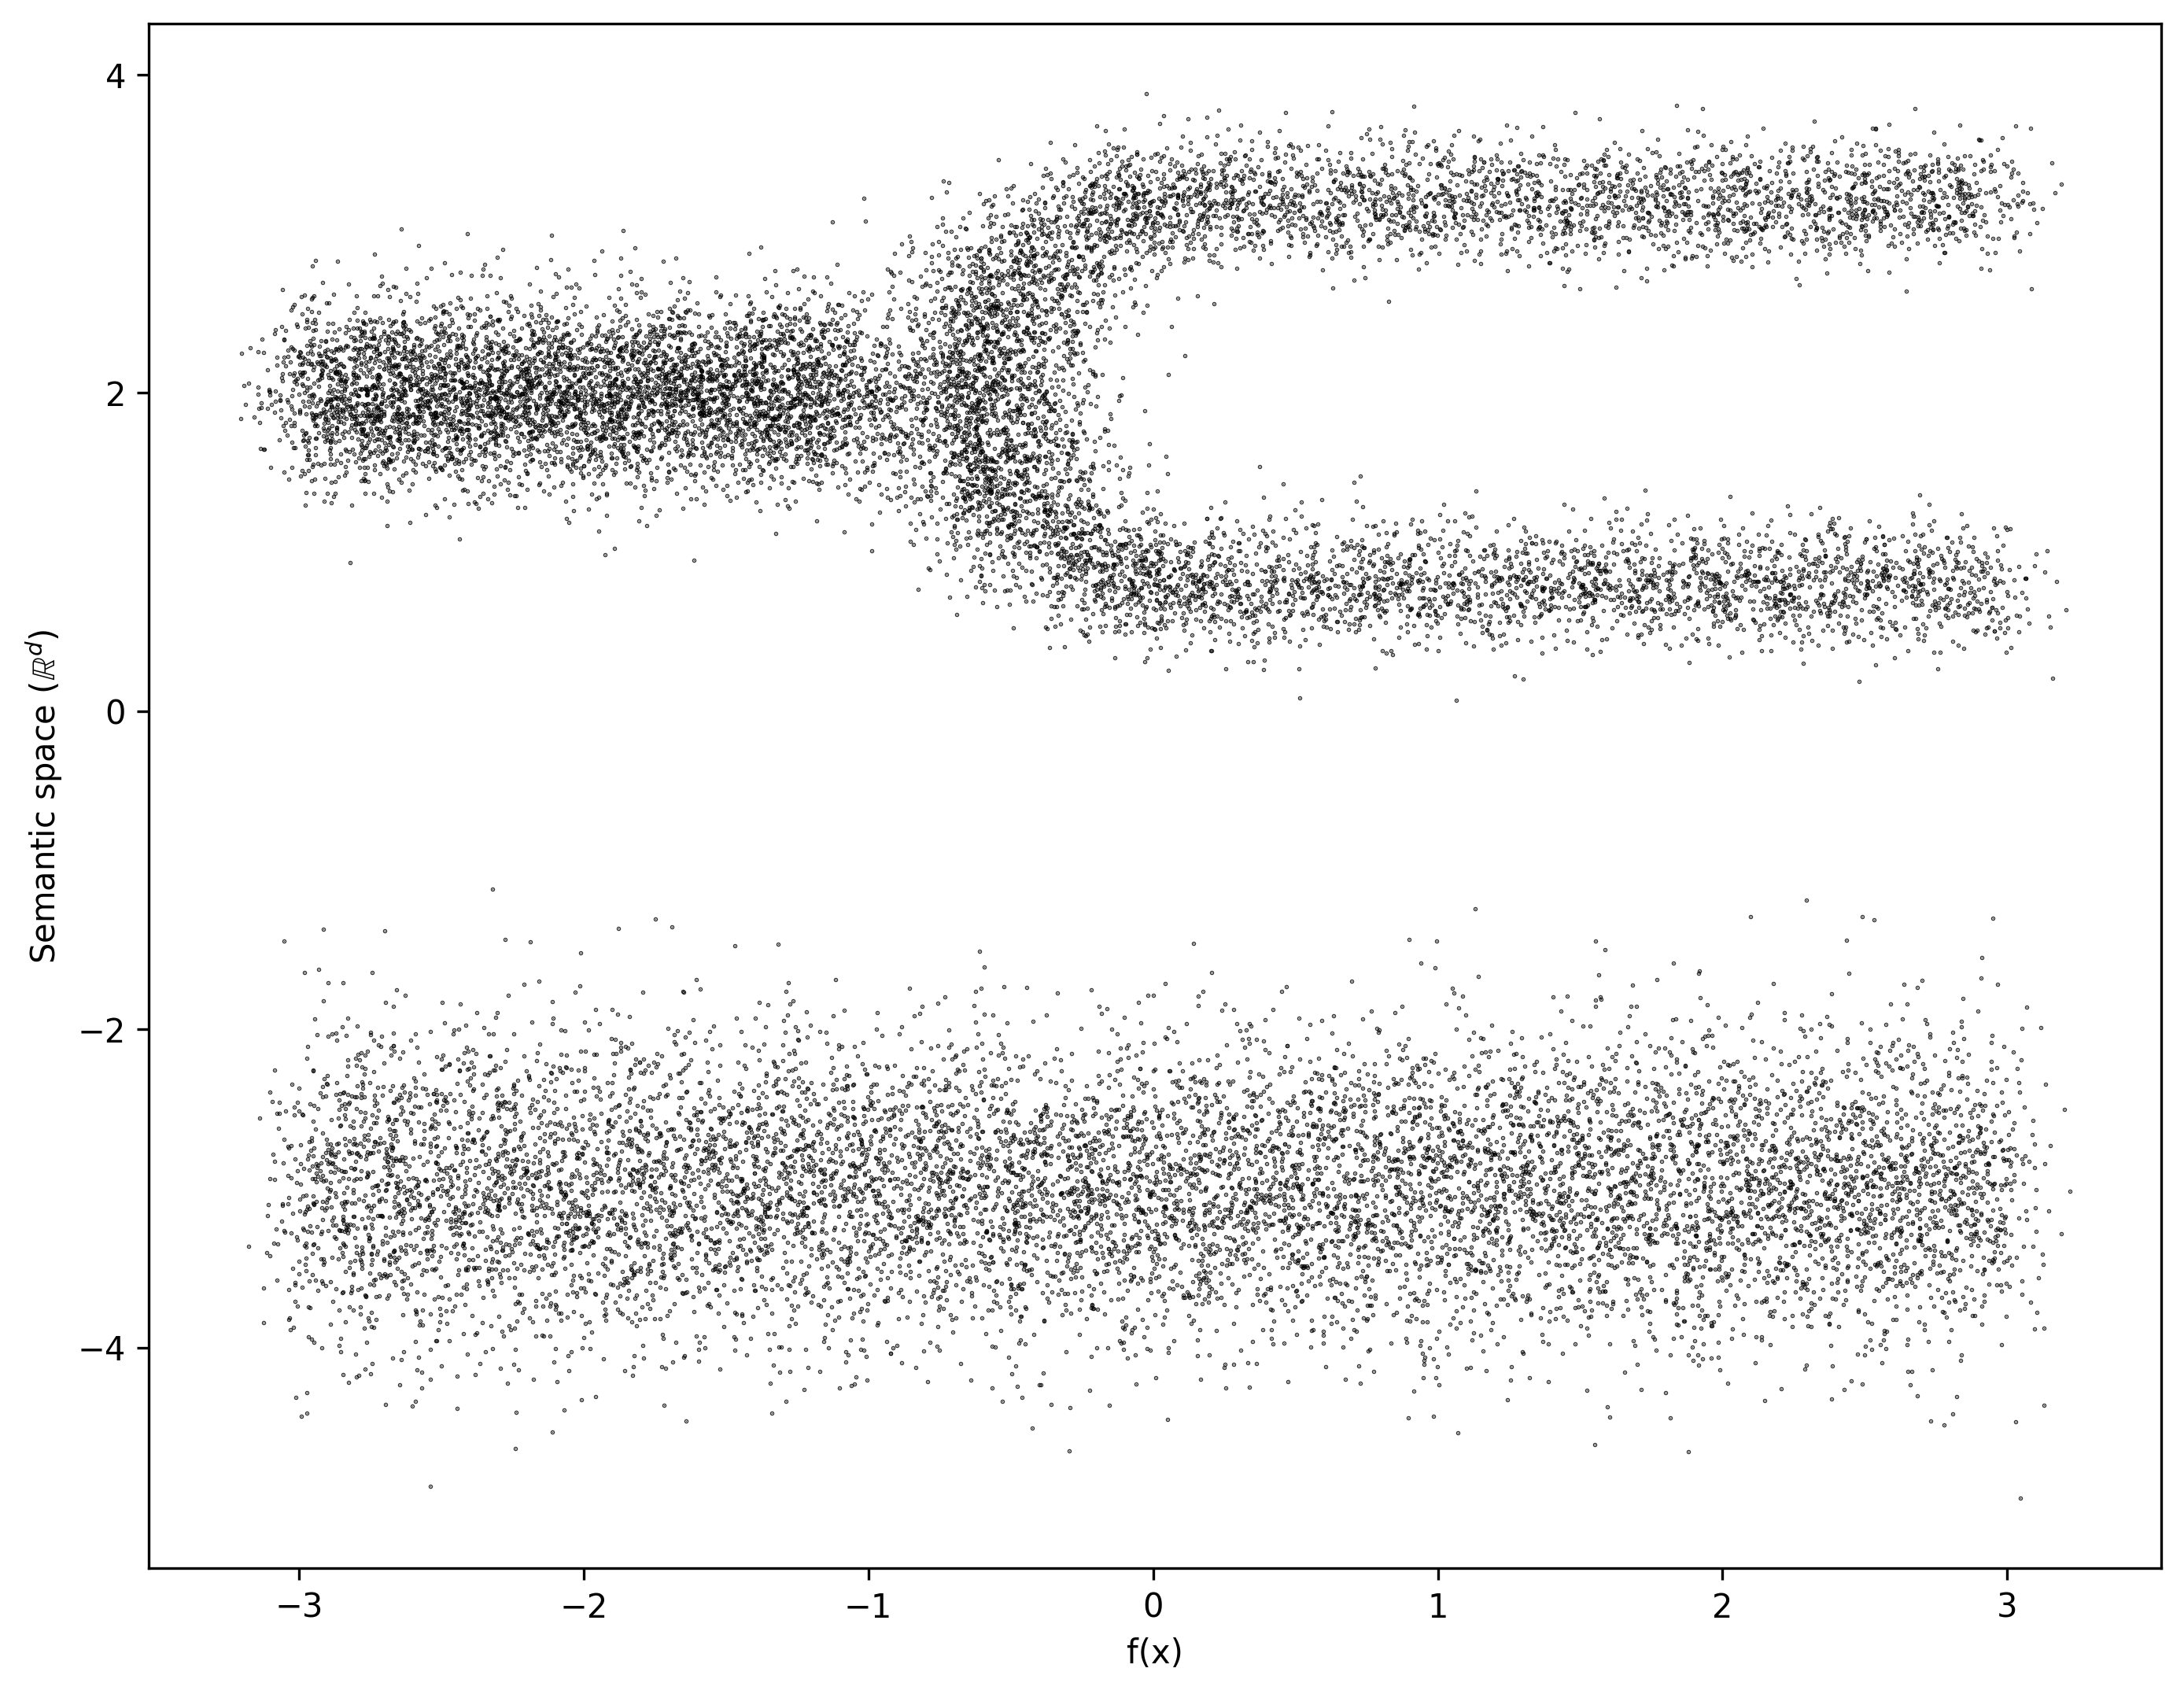

In [3]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(11)
fig.set_figheight(8.5)
ax.scatter(time,data,s=0.1,c='k',alpha=0.8)
ax.set_ylabel("Semantic space ($\mathbb{R}^d$)")
ax.set_xlabel("f(x)")
fig.dpi = 300
plt.show()

By setting `rate_sensitivity=0`, we skip the density computation step completely, reducing DBMapper to Mapper.

In [4]:
clusterer = DBSCAN(eps=0.1)
N_checkpoints = 10
TM = tm.TemporalMapper(
    time,
    data,
    clusterer,
    N_checkpoints = N_checkpoints,
    overlap = 0.5,
    rate_sensitivity=0,
)
TM.fit()

Step 1 of the Mapper procedure is to split the image of $f$ in $\mathbb{R}$ into overlapping bins. Our samples have $f(x) \in [-3,3]$, and we initialized the `TemporalMapper` with `N_checkpoints=10` and `overlap=0.5`, so it splits $[-3,3]$ into 10 intervals that overlap by half of the maximum allowable amount. 

We can visualize this open cover of $f(X)$ with a *sliceograph*, similar to a barcode diagram, where each bar in the graph shows the extent of one interval in the cover.

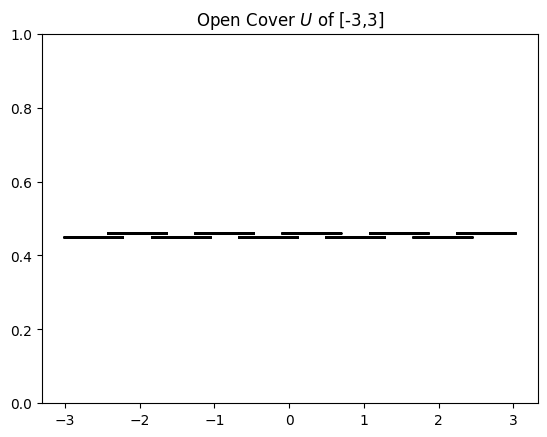

In [5]:
fig = plt.Figure(figsize = (10,3))
ax = plt.axes()
tmutils.sliceograph(TM, ax=ax)
plt.title("Open Cover $U$ of [-3,3]")
plt.show()

Steps 2 and 3 of the Mapper procedure are to cluster the points whose $f$ values lie within each interval, and then add one vertex to the output graph $G$ for each cluster. 

In the next cell, we will look at the clustering results (using DBSCAN) for the 5th and 6th intervals:

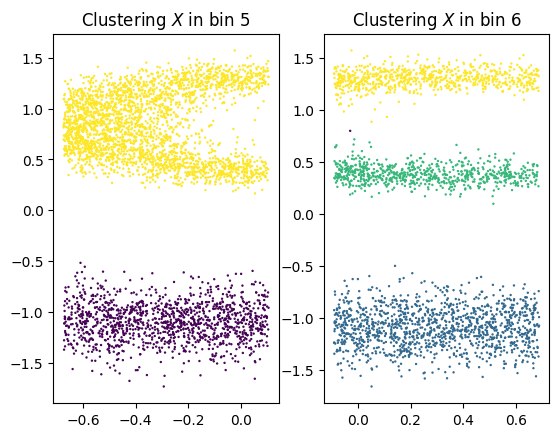

In [6]:
index_1 = 4
index_2 = 5
slice_1 = (TM.weights[index_1] >= 0.1).nonzero()
slice_2 = (TM.weights[index_2] >= 0.1).nonzero()
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_title("Clustering $X$ in bin 5")
ax1.scatter(TM.time[slice_1], TM.data[slice_1],
            s=0.5, c=TM.clusters[index_1,slice_1])
ax2.set_title("Clustering $X$ in bin 6")
ax2.scatter(TM.time[slice_2], TM.data[slice_2],
            s=0.5, c=TM.clusters[index_2,slice_2])
plt.show()

The points in bin 5 are partitioned into two clusters, so we will add two vertices $c^5_1$ and $c^5_2$ to the graph. The points in bin 6 are partitioned into three clusters, so we will add three vertices to the graph.

Finally, step 4 of Mapper tells us to draw edges between these vertices with weights given by the number of points in the intersection of the vertices. 

From the figure above, we can see that the left-hand size yellow cluster intersects the right-hand-size yellow and green clusters. The purple cluster intersects the blue cluster.

Once we add edges for each intersection $I_k \cap I_{k+1}$ in the open cover, we can visualize the resulting graph $G$ using one of the visualization options included in `temporalmapper.utilities`.

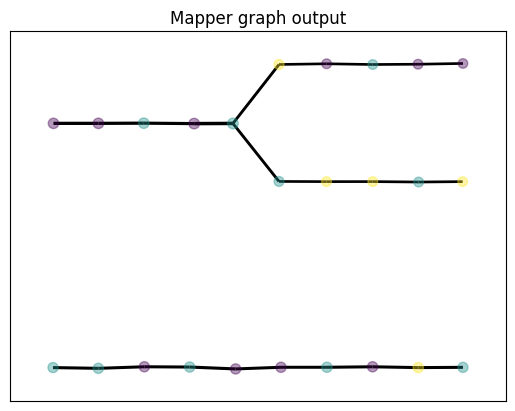

In [7]:
tmutils.time_semantic_plot(TM, TM.data)
plt.title("Mapper graph output")
plt.show()